<a href="https://www.kaggle.com/code/br0grammer/llm-text-classifier-pytorch-mlp?scriptVersionId=154768732" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
dataset = pd.read_csv("/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv")

In [3]:
import matplotlib.pyplot as plt

In [4]:
import random

In [5]:
stoi = {"[PAD]": 0,
       "[UNK]": 1}
itos = {0 : "[PAD]",
       1 : "[UNK]"}
total_text = set()
for index, row in dataset.iterrows():
    if random.random() <= 0.1:
        total_text.update(row["text"].lower().split())
stoi.update({char:i+2 for i, char in enumerate(sorted(total_text))})
itos.update({i+2:char for i, char in enumerate(sorted(total_text))})

In [6]:
itos[stoi['the']]

'the'

In [7]:
vocab_size = len(stoi)
vocab_size

45438

In [8]:
itos[0]

'[PAD]'

In [9]:
class Tokenizer:
    def __init__(self, stoi, itos, max_len=100):
        self.stoi = stoi
        self.itos = itos
        self.vocab_size = len(itos)
        self.max_len = max_len
    def encode(self, text, truncate=True):
        out = []
        if truncate:
            text = text.lower().split()[:self.max_len]
            for word in text:
                if word in stoi:
                    out.append(stoi[word])
                else:
                    out.append(1)
            out = [0] * max(0, abs(len(out) - self.max_len)) + out
        else:
            text = text.lower().split()
            for word in text:
                if word in stoi:
                    out.append(stoi[word])
                else:
                    out.append(1)
        return out
    def decode(self, ids):
        out = ""
        for token in ids:
            if token in itos:
                out += itos[token] + " "
        return out

In [10]:
context_len = 250

In [11]:
tokenizer = Tokenizer(stoi, itos, max_len=context_len)

In [12]:
for i, example in dataset.iterrows():
    print(example)
    break

text             Phones\n\nModern humans today are always on th...
label                                                            0
prompt_name                                     Phones and driving
source                                             persuade_corpus
RDizzl3_seven                                                False
Name: 0, dtype: object


(array([1.5710e+03, 1.8492e+04, 1.6514e+04, 5.2280e+03, 2.0070e+03,
        7.6000e+02, 2.5900e+02, 2.9000e+01, 6.0000e+00, 2.0000e+00]),
 array([   4. ,  169.2,  334.4,  499.6,  664.8,  830. ,  995.2, 1160.4,
        1325.6, 1490.8, 1656. ]),
 <BarContainer object of 10 artists>)

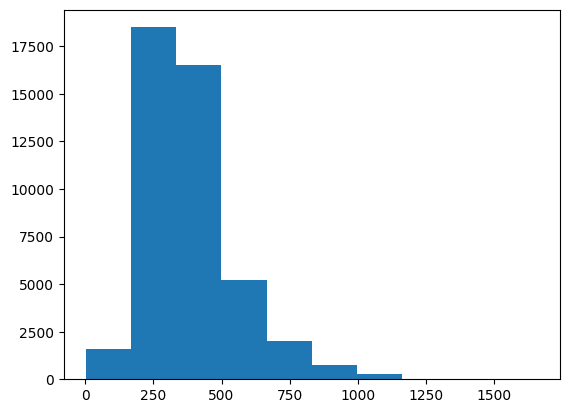

In [13]:
plt.hist([len(tokenizer.encode(example.text, truncate=False)) for i, example in dataset.iterrows()])

In [14]:
tokenizer.encode("Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built")[225:]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 8377,
 8353,
 20357,
 6348,
 5059,
 36726,
 40527,
 6267,
 17436,
 21969,
 40336,
 1,
 44243,
 20641,
 18323,
 11612,
 4479,
 7559]

In [15]:
context_len = 250

In [16]:
tokenizer = Tokenizer(stoi, itos, max_len=context_len)

In [17]:
tokenizer.decode(tokenizer.encode("Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built"))

'[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [18]:
import torch

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def build_dataset():
    xs, ys = [], []
    for index, row in dataset.iterrows():
        xs.append(tokenizer.encode(row["text"]))
        ys.append(row["label"])
    xs = torch.tensor(xs).to(device)
    ys = torch.tensor(ys).to(device)
    return xs, ys
xs, ys = build_dataset()

In [21]:
tokenizer.decode(xs[0].cpu().numpy())

"phones modern humans today are always on their phone. they are always on their phone more than 5 hours a day no stop [UNK] they do is text back and forward and just have group chats on social media. they even do it while driving. they are some really bad consequences when stuff happens when it comes to a phone. some certain areas in the united states ban phones from class rooms just because of it. when people have phones, they know about certain apps that they have [UNK] like facebook twitter instagram and snapchat. so like if a friend moves away and you want to be in contact you can still be in contact by posting videos or text messages. people always have different ways how to communicate with a phone. phones have changed due to our generation. driving is one of the way how to get around. people always be on their phones while doing it. which can cause serious problems. that's why there's a thing that's called no texting while driving. that's a really important thing to remember. so

In [22]:
ys[0]

tensor(0, device='cuda:0')

In [23]:
emb_dim = 10

In [24]:
# initialize parameters
n_hidden = 300
C = torch.randn(vocab_size, emb_dim).to(device)
w1 = torch.randn(context_len * emb_dim, n_hidden).to(device) / (context_len * emb_dim)**0.5
b1 = torch.randn(n_hidden).to(device) * 0.01
w2 = torch.randn(n_hidden, 2).to(device) / (n_hidden**0.5)
b2 = torch.randn(2).to(device) * 0.01

bngain = torch.ones((1, n_hidden)).to(device)
bnbias = torch.zeros((1, n_hidden)).to(device)

params = [C, w1, b1, w2, b2, bngain, bnbias]
for p in params:
    p.requires_grad = True

In [25]:
num_examples = len(xs)

In [26]:
# training params
num_epochs = 1000000
lr = 1
batch_size = 64

In [27]:
import torch.nn.functional as F

In [28]:
for epoch in range(num_epochs):
    selection = torch.randint(0, num_examples-1, (batch_size, ))
    ins = xs[selection]
    outs = ys[selection]
    emb = C[ins].view(-1, emb_dim * context_len)
    l1 = (emb @ w1) + b1
    l1 = bngain * ((l1 - l1.mean(0, keepdim=True)) / (l1.std(0, keepdim=True))) + bnbias
    l1 = l1.tanh()
    logits = ((l1 @ w2) + b2).sigmoid()
    for p in params:
        p.grad = None

    loss = F.cross_entropy(logits, outs)
    if epoch % 10000 == 0:
        print("Epoch:", epoch, ", loss:", loss.item())
    loss.backward()
    
    for p in params:
            p.data -= p.grad * (lr / (((epoch+1)/100)**0.5))

Epoch: 0 , loss: 0.6952809691429138
Epoch: 10000 , loss: 0.3344005048274994
Epoch: 20000 , loss: 0.3694623112678528
Epoch: 30000 , loss: 0.35187068581581116
Epoch: 40000 , loss: 0.32921501994132996
Epoch: 50000 , loss: 0.3134990632534027
Epoch: 60000 , loss: 0.31425565481185913
Epoch: 70000 , loss: 0.3291383385658264
Epoch: 80000 , loss: 0.3292178511619568
Epoch: 90000 , loss: 0.3218812346458435
Epoch: 100000 , loss: 0.32917320728302
Epoch: 110000 , loss: 0.31416600942611694
Epoch: 120000 , loss: 0.3134702146053314
Epoch: 130000 , loss: 0.3134545683860779
Epoch: 140000 , loss: 0.34522077441215515
Epoch: 150000 , loss: 0.3133523762226105
Epoch: 160000 , loss: 0.313314825296402
Epoch: 170000 , loss: 0.34460487961769104
Epoch: 180000 , loss: 0.3133767545223236
Epoch: 190000 , loss: 0.32969334721565247
Epoch: 200000 , loss: 0.31372666358947754
Epoch: 210000 , loss: 0.3289807140827179
Epoch: 220000 , loss: 0.31346744298934937
Epoch: 230000 , loss: 0.3134835660457611
Epoch: 240000 , loss: 0.

In [29]:
# with torch.no_grad():
#     selection = torch.randint(0, num_examples-1, (1,))
#     ins = xs[selection]
#     outs = ys[selection]
#     emb = C[ins].view(-1, emb_dim * context_len)
#     l1 = ((emb @ w1) + b1).tanh()
#     logits = ((l1 @ w2) + b2).sigmoid()
#     print(tokenizer.decode(ins[0].numpy()))
#     print("prediction:", torch.argmax(logits).item())
#     print("truth:", outs[0].item())

In [30]:
# with torch.no_grad():
#     while True:
#         selection = torch.randint(0, num_examples-1, (1,))
#         ins = xs[selection]
#         outs = ys[selection]
#         emb = C[ins].view(-1, emb_dim * context_len)
#         l1 = ((emb @ w1) + b1).tanh()
#         logits = ((l1 @ w2) + b2).sigmoid()
#         if outs[0].item() == 1:
#             print(tokenizer.decode(ins[0].numpy()))
#             print("prediction:", torch.argmax(logits).item(), "confidence:", (logits[0][torch.argmax(logits).item()]/logits.sum()).item())
#             print("truth:", outs[0].item())
#             print("selection index:", selection.item())
#             break

In [31]:
def prompt(essay):
    with torch.no_grad():
        ins = torch.tensor(tokenizer.encode(essay))
        emb = C[ins].view(-1, emb_dim * context_len)
        l1 = ((emb @ w1) + b1).tanh()
        logits = ((l1 @ w2) + b2).sigmoid()
        return round((logits[0][1] / logits[0].sum()).item(), 1)

In [32]:
prompt("furthermore, the introduction of cars into modern society assisted with means of transportation")

1.0

In [33]:
# tokenizer.decode(xs[96].numpy())

In [34]:
ys[96]

tensor(0, device='cuda:0')

In [35]:
test_dataset = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")

In [36]:
import csv

with open('submission.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["id", "generated"]
    
    writer.writerow(field)
    for index, row in test_dataset.iterrows():
        writer.writerow([row["id"], prompt(row["text"])])

In [37]:
answers = pd.read_csv("/kaggle/working/submission.csv")

In [38]:
for index, row in answers.iterrows():
    print(row)

id           0000aaaa
generated         1.0
Name: 0, dtype: object
id           1111bbbb
generated         1.0
Name: 1, dtype: object
id           2222cccc
generated         1.0
Name: 2, dtype: object
